# Trip dataset

This data set is about user driving data that describes the user's driving habits.
---------


In [ ]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, plot_precision_recall_curve, balanced_accuracy_score, recall_score, precision_score, f1_score

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

# statistical models
import statsmodels.api as sm

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# others
import logging
import math
from math import pi, log
import glob

# 1. Feature extraction

In this section, I present how to extract two new features from the trip data:
* <b> numTurns </b> - the number of turns in the trip [int]
* <b> numStops </b> - the number of stops in the trip [int]

Each trip in the trip data has a series of records including time (s), speed (m/s), and heading_degrees. To extract <b> numTurns </b> and <b> numStops </b> from it, let's define the logic:
* For <b> numTurns </b>: it can be derived via the heading degrees. Look at Fig. 1 (source: https://safety.fhwa.dot.gov/speedmgt/ref_mats/fhwasa1122/ch3.cfm), if the partial deflection angle is greater than 60 degrees, it is a turn. In other words, these (turning) points are at least 60 degrees higher/lower than their neighboring points. Therefore, our task is to detect these points. Moreover, we assume that a left turn followed immediately by a right turn (or vise versa) should be two separate turns. Hence, we count the number of local maximum and minimum points that are at least 60 degrees higher/lower than their neighbors.
* For <b> numStops </b>: it can be derived via the speed. It is also a detection problem. Clearly, we count the number of minimum points whose values are (approximately) 0 and last longer than 3 seconds.


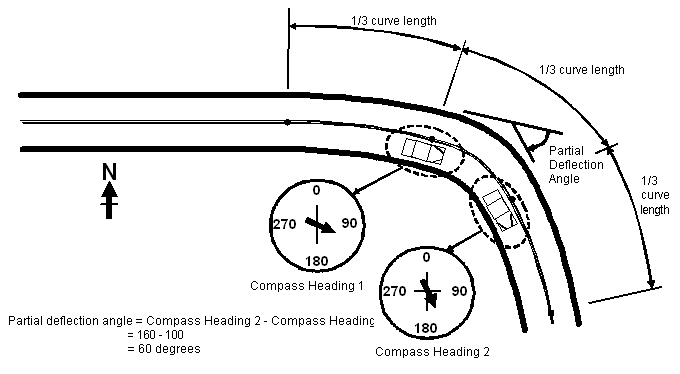

In [ ]:
 Image("/content/sample_data/turn.jpg")

To compute <b> numTurns </b>, I use [peakdetect](https://gist.github.com/sixtenbe/1178136). To compute <b> numStops </b>, I modify [peakdetect]() code to [zeropeakdetect]() function.

In [ ]:
# Copyright (C) 2016 Sixten Bergman
# License WTFPL
# This program is free software. It comes without any warranty, to the extent permitted by applicable law.
# You can redistribute it and/or modify it under the terms of the Do What The Fuck You Want To Public License, Version 2, as published by Sam Hocevar. 
# See http://www.wtfpl.net/ for more details.
# note that the function peakdetect is derived from code which was released to public domain see: http://billauer.co.il/peakdet.html

def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    if len(y_axis) != len(x_axis):
        raise ValueError("Input vectors y_axis and x_axis must have same length")
    # needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis

def peakdetect(y_axis, x_axis=None, lookahead=200, delta=0):
    """
    Converted from/based on a MATLAB script at: http://billauer.co.il/peakdet.html

    Function for detecting local maxima and minima in a signal.
    Discovers peaks by searching for values which are surrounded by lower or larger values for maxima and minima respectively

    Arguments:
    y_axis -- A list containing the signal over which to find peaks

    x_axis -- A x-axis whose values correspond to the y_axis list and is used in the return to specify the position of the peaks. 
              If omitted an index of the y_axis is used. (default: None)

    lookahead -- distance to look ahead from a peak candidate to determine if it is the actual peak (default: 200)
              '(samples / period) / f' where '4 >= f >= 1.25' might be a good value

    delta -- this specifies a minimum difference between a peak and the following points, before a peak may be considered a peak. 
            Useful to hinder the function from picking up false peaks towards to end of the signal. To work well delta should be set to delta >= RMSnoise * 5. (default: 0)
            When omitted delta function causes a 20% decrease in speed. When used Correctly it can double the speed of the function

    Return: Two lists [max_peaks, min_peaks] containing the positive and negative peaks respectively. 
            Each cell of the lists contains a tuple of: (position, peak_value) to get the average peak value do: 
            np.mean(max_peaks, 0)[1] on the results to unpack one of the lists into x, y coordinates do: x, y = zip(*max_peaks)
    """
    max_peaks = []
    min_peaks = []
    dump = []  # Used to pop the first hit which almost always is false

    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)

    # perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")

    # maxima and minima candidates are temporarily stored in mx and mn respectively
    mn, mx = np.Inf, -np.Inf

    # Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x

        ####look for max####
        if y < mx - delta and mx != np.Inf:
            # Maxima peak candidate found: look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index + lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                # set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index + lookahead >= length:
                    # end is within lookahead no more peaks can be found
                    break
                continue

        ####look for min####
        if y > mn + delta and mn != -np.Inf:
            # Minima peak candidate found: look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index + lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                # set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index + lookahead >= length:
                    # end is within lookahead no more peaks can be found
                    break

    # Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        # no peaks were found, should the function return empty lists?
        pass

    return [max_peaks, min_peaks]

In [ ]:
def zeropeakdetect(y_axis, x_axis=None, lookahead=3, delta=0):
    """
    Function for detecting local minima (0) whose duration is at least 3s in a signal.
    Modify the peakdetect function presented above

    Arguments:
    y_axis -- A list containing the signal over which to find peaks

    x_axis -- A x-axis whose values correspond to the y_axis list and is used in the return to specify the position of the peaks. 
              If omitted an index of the y_axis is used. (default: None)

    lookahead -- distance to look ahead from a peak candidate to determine if it is the actual peak (default: 3)
              '(samples / period) / f' where '4 >= f >= 1.25' might be a good value

    delta -- this specifies a minimum difference between a peak and the following points, before a peak may be considered a peak. 
            Useful to hinder the function from picking up false peaks towards to end of the signal. To work well delta should be set to delta >= RMSnoise * 5. (default: 0)
            When omitted delta function causes a 20% decrease in speed. When used Correctly it can double the speed of the function

    Return: Two lists [max_peaks, min_peaks] containing the positive and negative peaks respectively. 
            Each cell of the lists contains a tuple of: (position, peak_value) to get the average peak value do: 
            np.mean(max_peaks, 0)[1] on the results to unpack one of the lists into x, y coordinates do: x, y = zip(*max_peaks)
    """
    max_peaks = []
    min_peaks = []
    dump = []  # Used to pop the first hit which almost always is false

    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)

    # perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")

    # maxima and minima candidates are temporarily stored in mx and mn respectively
    mn, mx = np.Inf, -np.Inf

    # Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x

        ####look for max####
        if y < mx - delta and mx != np.Inf:
            # Maxima peak candidate found: look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index + lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                # set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index + lookahead >= length:
                    # end is within lookahead no more peaks can be found
                    break
                continue

        ####look for min####
        if y > mn + delta and mn != -np.Inf:
            # Minima peak candidate found: look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index + lookahead].min() > mn:
                idleft = idright = index
                while idleft>=0 and round(y_axis[idleft]-y_axis[index], 0)==0:
                    idleft -= 1
                while idright<length and round(y_axis[idright]-y_axis[index], 0)==0:
                    idright += 1
                # print(index, idleft, idright, x_axis[index:index + lookahead], x_axis[idleft:idright+1])
                # print(x_axis[max(index + lookahead - 1, idright)] - x_axis[min(idleft, index)])
                if x_axis[max(index + lookahead - 1, idright)] - x_axis[min(idleft, index)]>=3 and round(mn, 0)==0:
                    min_peaks.append([mnpos, mn])
                    dump.append(False)
                # set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index + lookahead >= length:
                    # end is within lookahead no more peaks can be found
                    break

    # Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        # no peaks were found, should the function return empty lists?
        pass

    return [max_peaks, min_peaks]

Let's take a look at some specific examples to see how these functions work.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


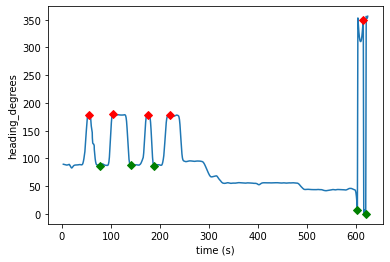

The number of turns is 10


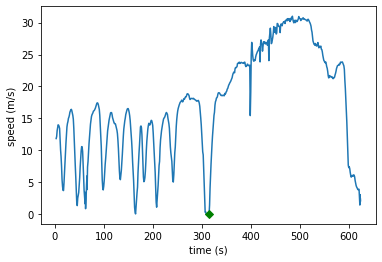

The number of stops is 1


In [ ]:
## first example
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/work_sample/trip_data_train/0001.csv', index_col=None, header=0)
# remove invalid values
data = data.dropna()

x = data['time_seconds']
y = data['heading_degrees']
_turnMax, _turnMin = peakdetect(y, x, 3, 65)
xm = [p[0] for p in _turnMax]
ym = [p[1] for p in _turnMax]
xn = [p[0] for p in _turnMin]
yn = [p[1] for p in _turnMin]

plot = plt.plot(x, y)
plt.xlabel('time (s)')
plt.ylabel('heading_degrees')
plt.plot(xm, ym, "rD")
plt.plot(xn, yn, "gD")
plt.show()
print('The number of turns is', len(_turnMax)+len(_turnMin))

z = data['speed_meters_per_second']
_ , _stopMin = zeropeakdetect(z, x, 3, 10)
xn = [p[0] for p in _stopMin]
zn = [p[1] for p in _stopMin]

plot = plt.plot(x, z)
plt.xlabel('time (s)')
plt.ylabel('speed (m/s)')
plt.plot(xn, zn, "gD")
plt.show()
print('The number of stops is', len(xn))

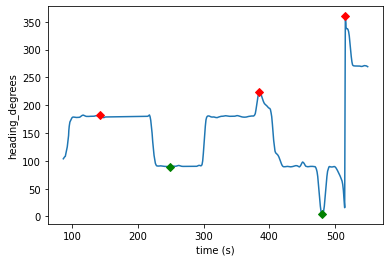

The number of turns is 5


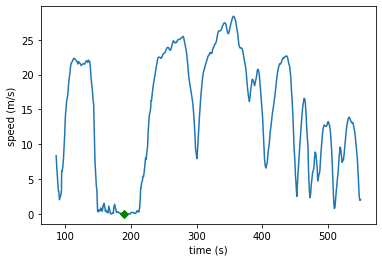

The number of stops is 1


In [ ]:
## second example
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/work_sample/trip_data_train/0003.csv', index_col=None, header=0)
# remove invalid values
data = data.dropna()

x = data['time_seconds']
y = data['heading_degrees']
_turnMax, _turnMin = peakdetect(y, x, 3, 65)
xm = [p[0] for p in _turnMax]
ym = [p[1] for p in _turnMax]
xn = [p[0] for p in _turnMin]
yn = [p[1] for p in _turnMin]

plot = plt.plot(x, y)
plt.xlabel('time (s)')
plt.ylabel('heading_degrees')
plt.plot(xm, ym, "rD")
plt.plot(xn, yn, "gD")
plt.show()
print('The number of turns is', len(_turnMax)+len(_turnMin))

z = data['speed_meters_per_second']
_ , _stopMin = zeropeakdetect(z, x, 3, 10)
xn = [p[0] for p in _stopMin]
zn = [p[1] for p in _stopMin]

plot = plt.plot(x, z)
plt.xlabel('time (s)')
plt.ylabel('speed (m/s)')
plt.plot(xn, zn, "gD")
plt.show()
print('The number of stops is', len(xn))

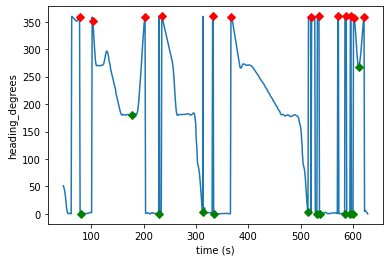

The number of turns is 25


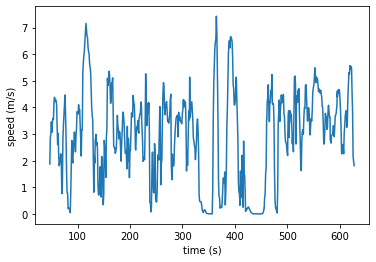

The number of stops is 0


In [ ]:
## third example
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/work_sample/trip_data_train/0013.csv', index_col=None, header=0)
# remove invalid values
data = data.dropna()

x = data['time_seconds']
y = data['heading_degrees']
_turnMax, _turnMin = peakdetect(y, x, 3, 65)
xm = [p[0] for p in _turnMax]
ym = [p[1] for p in _turnMax]
xn = [p[0] for p in _turnMin]
yn = [p[1] for p in _turnMin]

plot = plt.plot(x, y)
plt.xlabel('time (s)')
plt.ylabel('heading_degrees')
plt.plot(xm, ym, "rD")
plt.plot(xn, yn, "gD")
plt.show()
print('The number of turns is', len(_turnMax)+len(_turnMin))

z = data['speed_meters_per_second']
_ , _stopMin = zeropeakdetect(z, x, 3, 10)
xn = [p[0] for p in _stopMin]
zn = [p[1] for p in _stopMin]

plot = plt.plot(x, z)
plt.xlabel('time (s)')
plt.ylabel('speed (m/s)')
plt.plot(xn, zn, "gD")
plt.show()
print('The number of stops is', len(xn))

The results are as expected from the logic. <i> However, in my opinion, the first two results look reasonable while the last one (25 turns in 600s (1h) duration) is not. This one needs more investigation especially about the logic in the future. </i>

Now apply for the whole training trip data.

In [ ]:
# (Training) Trip Data 
path = r'/content/drive/MyDrive/Colab Notebooks/work_sample/trip_data_train'
all_files = glob.glob(path + "/*.csv")

numTurns = []
numStops = []
for filename in all_files:
    data = pd.read_csv(filename, index_col=None, header=0)
    # remove invalid values
    data = data.dropna()
    
    x = data['time_seconds']
    y = data['heading_degrees']
    z = data['speed_meters_per_second']

    _turnMax, _turnMin = peakdetect(y, x, 3, 65)
    _stopMax, _stopMin = zeropeakdetect(z, x, 3, 10)
    numTurns.append(len(_turnMax) + len(_turnMin))
    numStops.append(len(_stopMin))

#2. Data exploratory analysis

Now take a look at the model training data.

In [ ]:
# training data
traindt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/work_sample/model_data_train.csv', index_col=None, header=0)
traindt.insert(15, 'numStops', numStops)
traindt.insert(16, 'numTurns', numTurns)

In [ ]:
# show basic statistics
traindt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   filename   1000 non-null   object 
 1   feature1   1000 non-null   bool   
 2   feature2   1000 non-null   bool   
 3   feature3   1000 non-null   bool   
 4   feature4   1000 non-null   float64
 5   feature5   1000 non-null   float64
 6   feature6   1000 non-null   float64
 7   feature7   1000 non-null   float64
 8   feature8   1000 non-null   int64  
 9   feature9   1000 non-null   int64  
 10  feature10  1000 non-null   int64  
 11  feature11  1000 non-null   float64
 12  feature12  1000 non-null   float64
 13  feature13  1000 non-null   float64
 14  feature14  1000 non-null   float64
 15  numStops   1000 non-null   int64  
 16  numTurns   1000 non-null   int64  
 17  y          1000 non-null   int64  
dtypes: bool(3), float64(8), int64(6), object(1)
memory usage: 120.2+ KB


There is no missing data in the training data. It includes 3 binary features and 13 numerical features.

## 2.1. Take a look at the output (y)

310

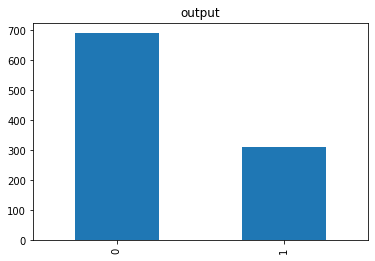

In [ ]:
traindt['y'].value_counts().plot.bar(title='output')
sum(traindt['y'])

It shows that there are 69% samples 0's and 31% samples 1's. It is mild imbalance, which may not a problem. 

<i> However, I will investigate it more about how to deal with this imbalanced problem to improve the results such as using over-sampling and under-sampling techniques. </i>

## 2.2. Take a look at the features


### a. Binary features (feature1, feature2, feature3)

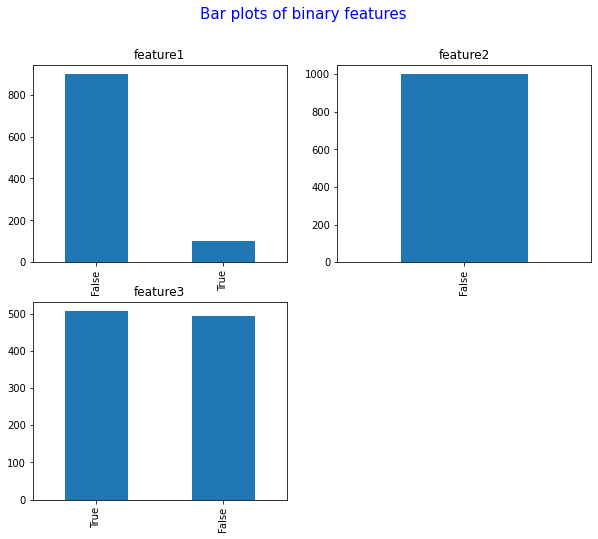

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
plt.suptitle('Bar plots of binary features', size=15, color='blue')
plt.subplot(221)
traindt['feature1'].value_counts().plot(kind='bar', title = 'feature1')
plt.subplot(222)
traindt['feature2'].value_counts().plot(kind='bar', title = 'feature2')
plt.subplot(223)
traindt['feature3'].value_counts().plot(kind='bar', title = 'feature3')
plt.show()

It can be seen that the values of feature2 are all False. In other words, it cannot indicate anything about the output. Therefore, it can be removed.

#### Relationship with output

In [ ]:
traindt[['feature1', 'feature3', 'y']].groupby('y').sum()

,feature1,feature3
y,,
0,98,373
1,4,134


It shows that feature1 and feature3 are related with the output and feature1 seems to have stronger relationship with the output than feature3.

Two other features are converted to numerical values.

In [ ]:
num_feature1 = traindt['feature1']*1
num_feature3 = traindt['feature3']*1

### b. Numerical features

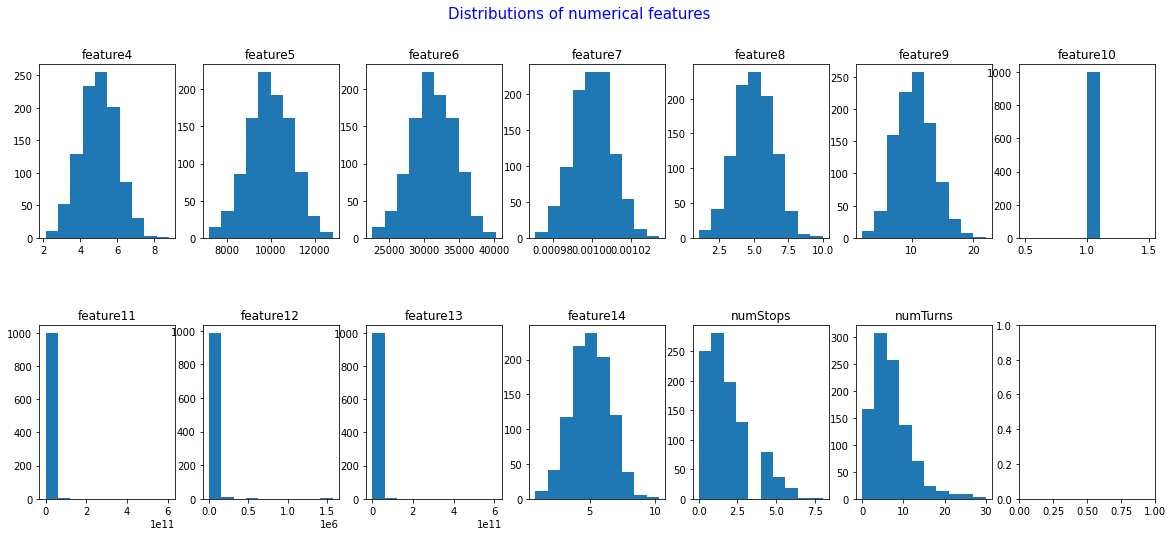

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(20, 8))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of numerical features', size=15, color='blue')

features = list(traindt.columns)[4:17]
for ax, feature, name in zip(axes.flatten(), features, features):
    ax.hist(traindt[feature])
    ax.set(title=name)

Take a closer look at four features (feature10, feature11, feature12, feature13):


*   feature10: its values are all 1. In other words, it cannot indicate anything about the output. Therefore, it can be removed.
*   feature11, feature12, feature13: the range of their values is huge. A significant number of samples with small values in range (0,1). Therefore, they can be transformed using log transformation.



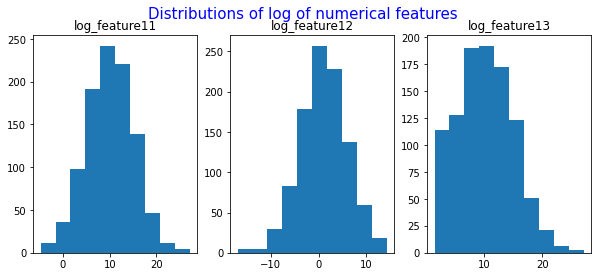

In [ ]:
log_feature11 = [math.log(traindt['feature11'][i]) for i in range(len(traindt['feature11']))]
log_feature12 = [math.log(traindt['feature12'][i]) for i in range(len(traindt['feature12']))]
log_feature13 = [math.log(traindt['feature13'][i]) for i in range(len(traindt['feature13']))]

fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(10, 4))
fig.subplots_adjust(hspace=0.5)
fig.suptitle('Distributions of log of numerical features', size=15, color='blue')
plt.subplot(131)
plt.hist(log_feature11)
plt.title('log_feature11')
plt.subplot(132)
plt.hist(log_feature12)
plt.title('log_feature12')
plt.subplot(133)
plt.hist(log_feature13)
plt.title('log_feature13')
plt.show()

It can be seen that their distribution look more reasonable.

### c. Correlation matrix (including both binary features, numerical features and output)

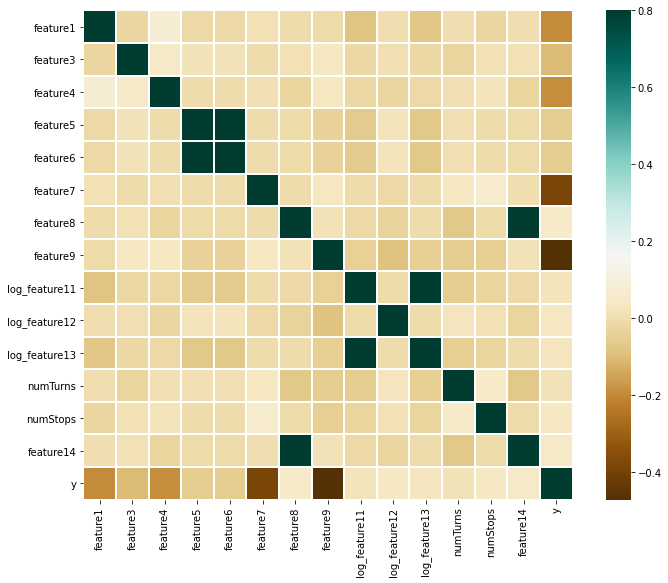

In [ ]:
bin_features = ['feature1', 'feature3']
num_features = ['feature4', 'feature5', 'feature6', 'feature7', 'feature8', 'feature9', 'log_feature11', 'log_feature12', 'log_feature13', 'feature14', 'numTurns', 'numStops']
pro_traindt = pd.DataFrame(num_feature1)
pro_traindt.insert(1, 'feature3', num_feature3)
for id, var in enumerate(num_features[0:6]):
  pro_traindt.insert(id+2, var, traindt[var])
pro_traindt.insert(8, 'log_feature11', log_feature11)
pro_traindt.insert(9, 'log_feature12', log_feature12)
pro_traindt.insert(10, 'log_feature13', log_feature13)
pro_traindt.insert(11, 'numTurns', numTurns)
pro_traindt.insert(12, 'numStops', numStops)
pro_traindt.insert(13, 'feature14', traindt['feature14'])
pro_traindt.insert(14, 'y', traindt['y'])
 
#correlation matrix
corrmat = pro_traindt.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, cmap='BrBG', linewidth=1, vmax=.8, square=True);

It is easy to notice that there are black green colored squares corresponding to value 1:

*   The first one refers to 'feature5' and 'feature6'
*   The second one refers to 'feature8' and 'feature14'
*   The third one refers to 'log_feature11' and 'log_feature13'

They are multicollinearity cases. In other words, they give almost the same information. Therefore, one feature in each case can be removed. Specifically, 'feature6', 'feature14', and 'log_feature13' are removed.

In addition, it shows that 'feature1', 'feature4', 'feature7', 'feature9' have stronger relationship with output (y) than other features. We will go further in the next sections.

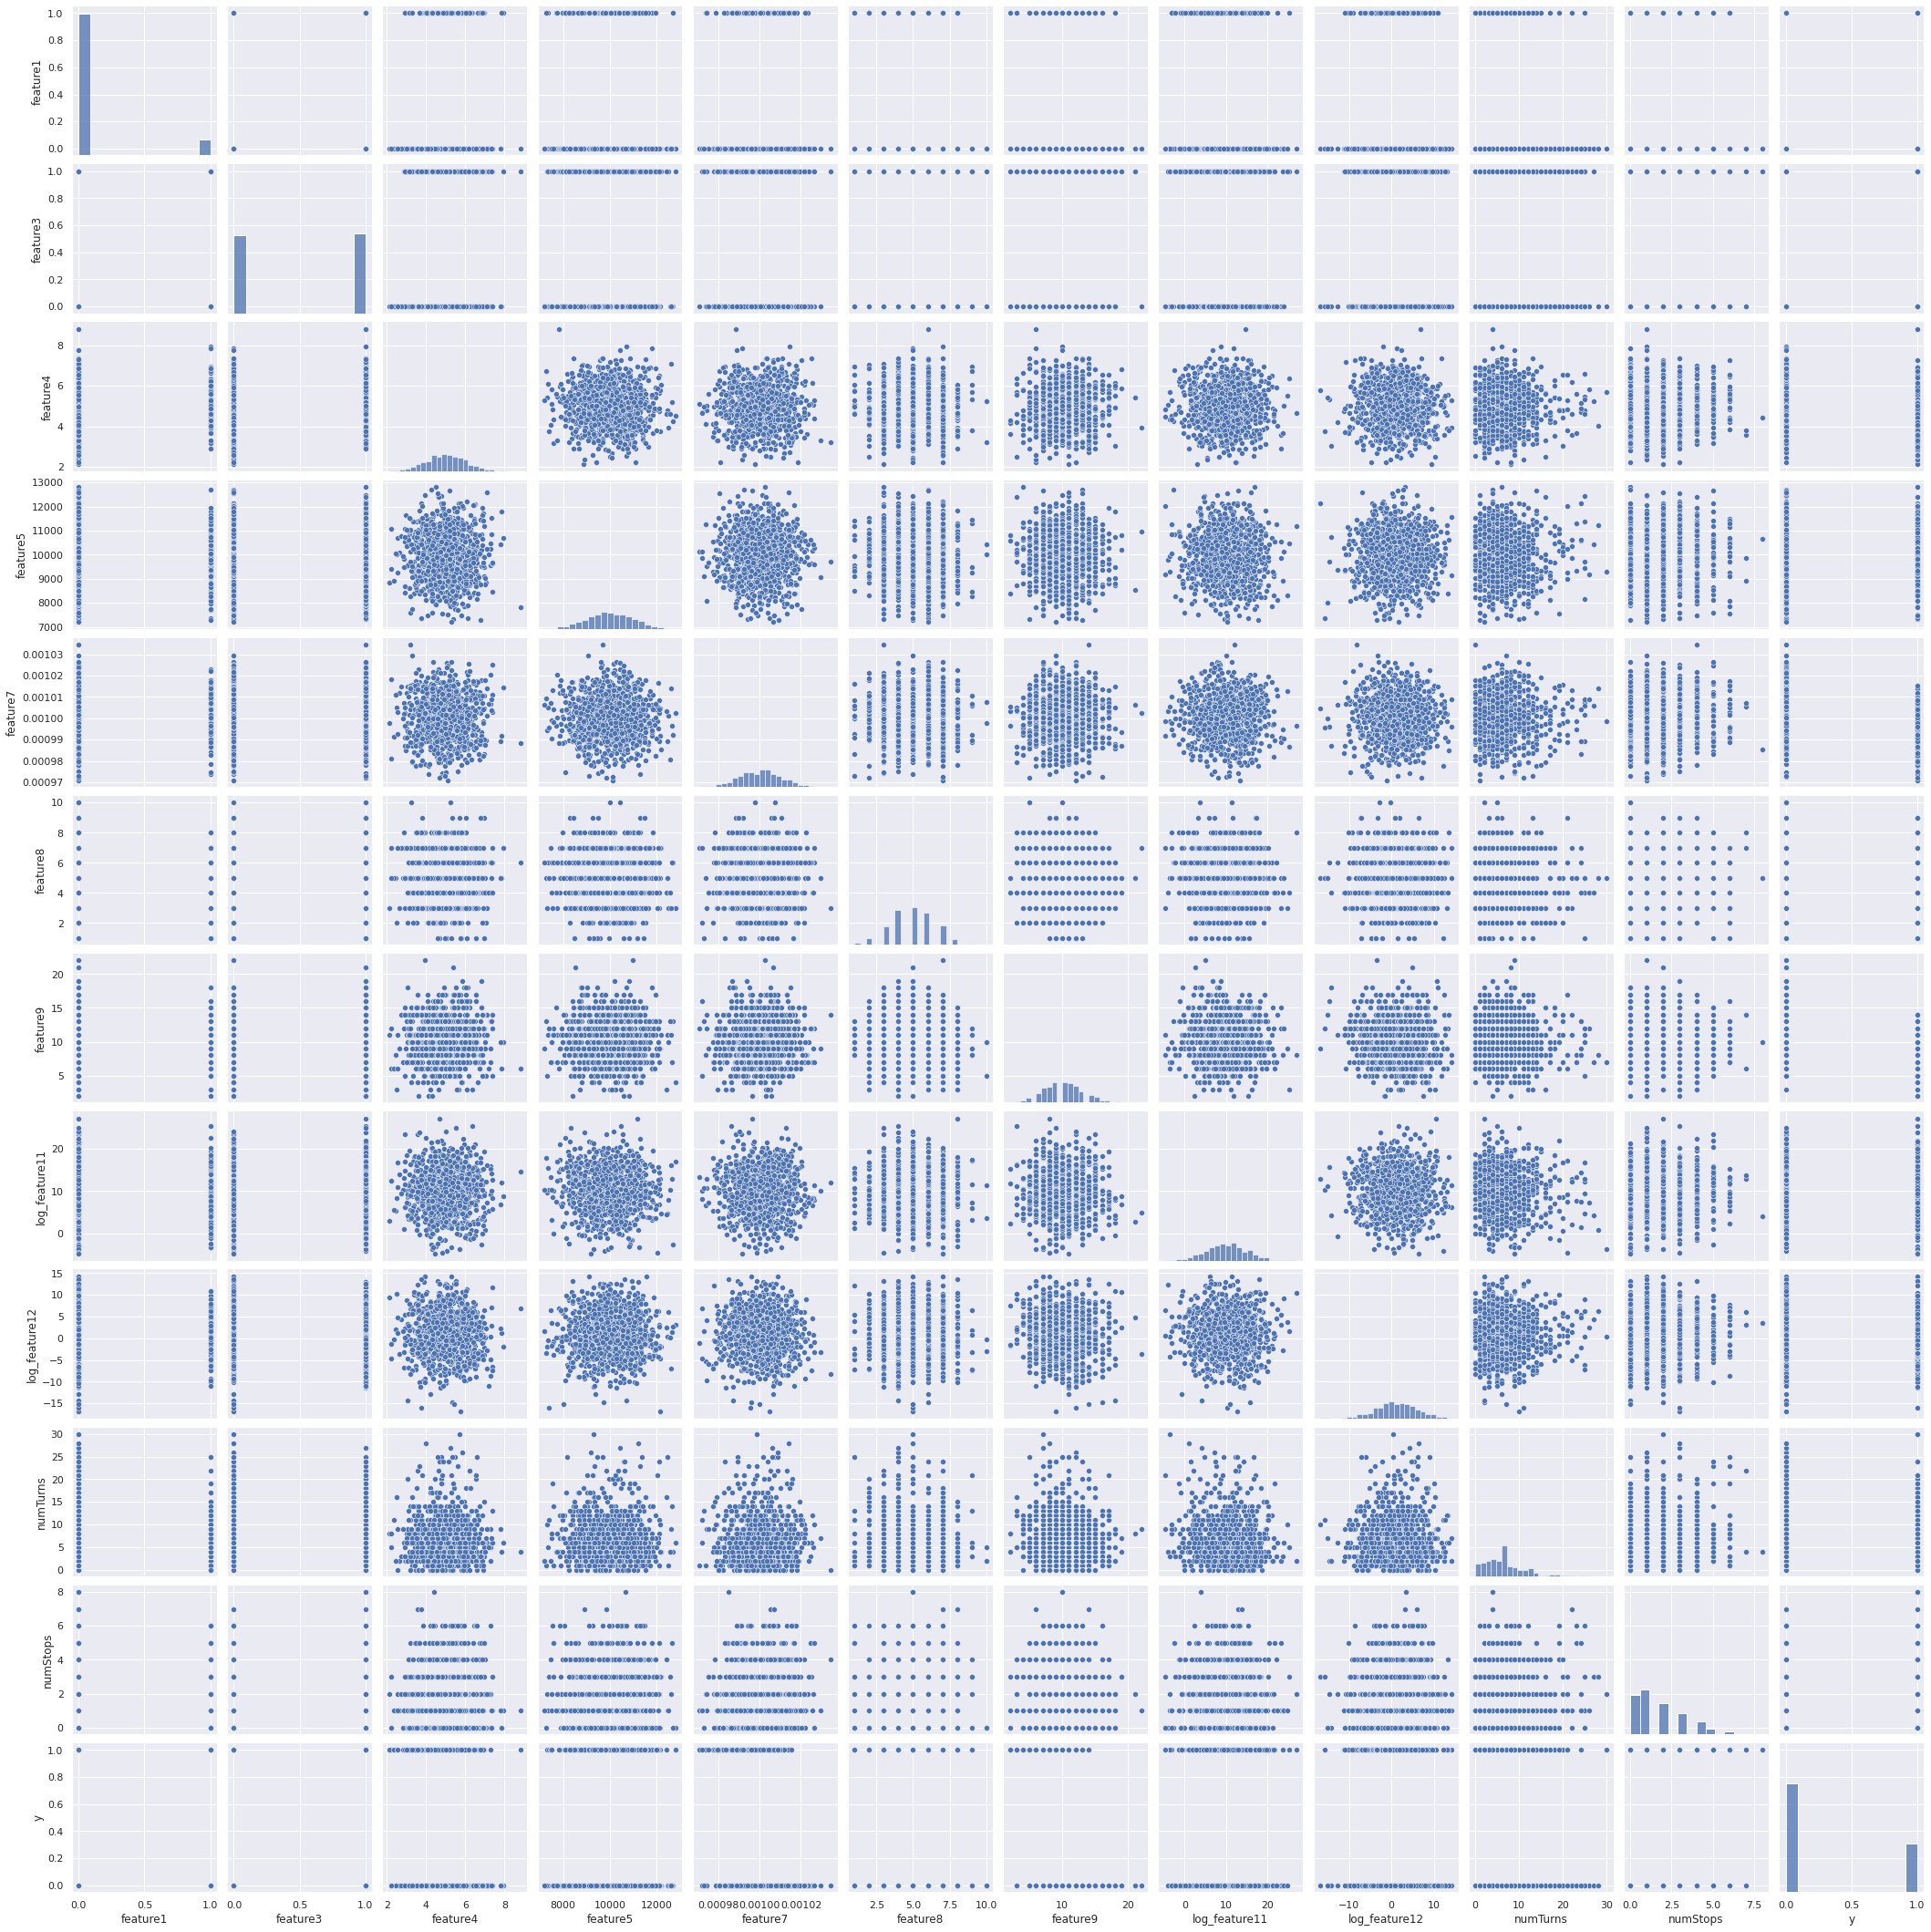

In [ ]:
sel_colnames = ['feature1', 'feature3', 'feature4', 'feature5', 'feature7', 'feature8', 'feature9', 'log_feature11', 'log_feature12', 'numTurns', 'numStops', 'y']
final_traindt = pro_traindt[sel_colnames]
# scatterplot
sns.set()
sns.pairplot(final_traindt)
plt.show()

The scatter plot shows that there is no homoscedasticity problem.

# 3. Models
Now data are ready to train a model and make predictions. Our problem is to identify the relationship between output (y) with other features, which is a classification and regression problem. The choice of models include:

- Logistic Regression
- KNN or k-Nearest Neighbors
- Naive Bayes classifier
- Linear/Quadratic Discriminant Analysis
- Support Vector Machines
- Decision Tree
- Random Forrest
- Multi-layer Perceptron
- GradientBoostingClassifier
- XGBClassifier




## 3.1. Logistic regression

Logistic Regression is a simple and useful model: it measures the relationship between the output (y) and features by estimating probabilities using a logistic function. Reference [Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression).

First, I apply the logistic regression in [statsmodels](https://www.statsmodels.org/stable/index.html) since it gives the statistical measurements such as AIC, BIC, log-likelihood to evaluate the selected model and p-value to evalute the features. 

#### <u> Rescale (Normalization or Standardization) </u>

The above distributions of features show that the features have different scales. Some algorithms such as tree-based algorithms are insensitive to it, but other methods such as distanced-based methods or neural networks are sensitive to it. In here, standardization is applied instead of normalization since it does not have a bounding range. So, it does not affect upon data even if data have outliers.

Now take a look at how the logistic regression works for data with and without rescaling.

In [ ]:
# data standardization with  sklearn
sel_features = sel_colnames[0:11]
stand_features = pro_traindt[sel_features].copy()
for id, col in enumerate(sel_features):
    if id>1:
      # fit on training data column
      scale = StandardScaler().fit(pro_traindt[[col]])
      # transform the training data column
      stand_features[col] = scale.transform(pro_traindt[[col]])

<u> Note: </u> Divide the training data into the train set and validation set with a usual ratio 7/3.

In [ ]:
# without rescaling (standardizing)
X_train, X_val, y_train, y_val = train_test_split(pro_traindt[sel_features], pro_traindt['y'], test_size=0.3, random_state=0)
logreg_st_model = sm.Logit(y_train, X_train).fit()
print("Results for data without rescaling", logreg_st_model.summary2())
# with rescaling (standardizing)
X_train, X_val, y_train, y_val = train_test_split(stand_features, pro_traindt['y'], test_size=0.3, random_state=0)
logreg_st_model = sm.Logit(y_train, X_train).fit()
print("Results for data with rescaling", logreg_st_model.summary2())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.429021
         Iterations 16
Results for data without rescaling                            Results: Logit
Model:                Logit             Pseudo R-squared:  0.289     
Dependent Variable:   y                 AIC:               622.6301  
Date:                 2021-02-25 22:10  BIC:               672.6919  
No. Observations:     700               Log-Likelihood:    -300.32   
Df Model:             10                LL-Null:           -422.40   
Df Residuals:         689               LLR p-value:       9.1359e-47
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       16.0000                                        
---------------------------------------------------------------------
                Coef.    Std.Err.    z     P>|z|    [0.025    0.975] 
---------------------------------------------------------------------
feature1        -2.7210    0.5949  -4.5740 0.0000 

It can be seen that although both cases give the same results of features that are statistically significant based on p-value values smaller than the usual significance level of 0.05, the coefficients of the case without rescaling may mislead: coefficient of feature7 is too large comparing with others. In addition, for fair comparison among different methods, rescaling (standardizing) data is implemented before applying models.

Moreover, the results show that based on p-values, some features (feature1, feature3, feature4, feature5, feature7, feature8, feature9) are statistically significant while other features are not. Let's check the model with all features and the model with only statistically significant features. 

In [ ]:
sig_features = ['feature1', 'feature3', 'feature4', 'feature5', 'feature7', 'feature8', 'feature9']
## performing predictions on the validation set
# use all features
y_hat = logreg_st_model.predict(X_val) 
y_pred = list(map(round, y_hat)) 
# accuracy score of the model 
print('Use all features: Accuracy of logistic regression classifier on validation set: {:.2f}'.format(accuracy_score(y_val, y_pred)))
# use only sig_features
logreg_st_model = sm.Logit(y_train, X_train[sig_features]).fit()
y_hat = logreg_st_model.predict(X_val[sig_features]) 
y_pred = list(map(round, y_hat)) 
# accuracy score of the model 
print('Use only sig_features: Accuracy of logistic regression classifier on validation set: {:.2f}'.format(accuracy_score(y_val, y_pred)))

Use all features: Accuracy of logistic regression classifier on validation set: 0.87
Optimization terminated successfully.
         Current function value: 0.341956
         Iterations 8
Use only sig_features: Accuracy of logistic regression classifier on validation set: 0.86


The results are almost the same. Therefore, it seems to be ok to use only the features that are statistically significant. In here, I will present the results of both two sets of features for all models.

## 3.2. Use all processed features

I will apply different models listed above. Accuracy of model is presented. Balanced accuray is also presented to check how the mild imbalanced problem affects the result.


1. Test the logistic regression again with [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) in scikit-learn.

In [ ]:
# Logistic regression
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_val)
acc_log = logreg.score(X_val, y_val)
bacc_log = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of logistic regression classifier on validation set: %3.2f, %3.2f" % (acc_log, bacc_log))

Accuracy and balance accuracy of logistic regression classifier on validation set: 0.88, 0.85


2. The k-Nearest Neighbors algorithm (kNN) is a non-parametric method used for classification and regression: A sample is classified by a majority vote of its neighbors, with the sample being assigned to the class most common among its k nearest neighbors. Reference [Wikipedia](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).

    kNN accuracy is much worse than Logistic regression.

In [ ]:
# kNN
knn = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)
y_pred = knn.predict(X_val)
acc_knn = knn.score(X_val, y_val)
bacc_knn = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of kNN classifier on validation set: %3.2f, %3.2f" % (acc_knn, bacc_knn))

Accuracy and balance accuracy of kNN classifier on validation set: 0.74, 0.70


3. Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes' theorem with strong independence assumptions between the features. Reference [Wikipedia](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).

    It gives better accuracy than kNN, but worse than Logistic regression.

In [ ]:
# naive Bayes
nb = GaussianNB().fit(X_train, y_train)
y_pred = nb.predict(X_val)
acc_nb = nb.score(X_val, y_val)
bacc_nb = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of naive Bayes classifier on validation set: %3.2f, %3.2f" % (acc_nb, bacc_nb))

Accuracy and balance accuracy of naive Bayes classifier on validation set: 0.84, 0.85


4. Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) classifiers fit a Gaussian density to each class. While LDA assumes all classes share the same covariance matrix (it generates a linear decision boundary), QDA assumes classes have different covariance matrix. References [Wikipedia](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) 

    LDA model generates the highest accuracy among the models evaluated so far while QDA generates worse than Logistic regression.

In [ ]:
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
y_pred = lda.predict(X_val)
acc_lda = lda.score(X_val, y_val)
bacc_lda = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of lda classifier on validation set: %3.2f, %3.2f" % (acc_lda, bacc_lda))
# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
y_pred = qda.predict(X_val)
acc_qda = qda.score(X_val, y_val)
bacc_qda = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of qda classifier on validation set: %3.2f, %3.2f" % (acc_qda, bacc_qda))

Accuracy and balance accuracy of lda classifier on validation set: 0.89, 0.86
Accuracy and balance accuracy of qda classifier on validation set: 0.85, 0.85


5. Support Vector Machines, supervised learning methods, used for classification and regression analysis by generating non-probabilistic binary linear classifier. Reference [Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine).

    Its result is worse than Logistic regression and LDA.

In [ ]:
# svm
SVM = svm.SVC().fit(X_train, y_train)
y_pred = SVM.predict(X_val)
acc_svm = SVM.score(X_val, y_val)
bacc_svm = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of svm classifier on validation set: %3.2f, %3.2f" % (acc_svm, bacc_svm))

Accuracy and balance accuracy of svm classifier on validation set: 0.86, 0.82


6. Decision tree maps features (tree branches) to conclusions about the output value (tree leaves). Reference [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning).

    Its accuracy is worse than other models except kNN.

In [ ]:
# decision tree
dct = tree.DecisionTreeClassifier().fit(X_train, y_train)
y_pred = dct.predict(X_val)
acc_dct = dct.score(X_val, y_val)
bacc_dct = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of decision tree classifier on validation set: %3.2f, %3.2f" % (acc_dct, bacc_dct))

Accuracy and balance accuracy of decision tree classifier on validation set: 0.81, 0.79


7. Random Forests is an ensemble learning method for classification and other tasks. It constructs a multitude of decision trees (n_estimators=100) at training time and outputting the class that is the mode of the classes (classification). Reference [Wikipedia](https://en.wikipedia.org/wiki/Random_forest).

    It results in the same accuracy as SVM, but still worse than Logistic regression and LDA.

In [ ]:
# random forest
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
y_pred = rf.predict(X_val)
acc_rf = rf.score(X_val, y_val)
bacc_rf = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of random forest classifier on validation set: %3.2f, %3.2f" % (acc_rf, bacc_rf))

Accuracy and balance accuracy of random forest classifier on validation set: 0.86, 0.81


8. Multilayer perceptron is a supervised learning algorithm that learns a non-linear function approximator for either classification or regression. Reference [Wikipedia](https://en.wikipedia.org/wiki/Multilayer_perceptron)

    Its accuracy is good, but still worse than Logistic regression and LDA. <u> Note: </u> The choices of number of layers and number of nodes per layer have great impact on the results. It needs more time to investigate.

In [ ]:
# multilayer perceptron
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2,2), random_state=1).fit(X_train, y_train)
y_pred = mlp.predict(X_val)
acc_mlp = mlp.score(X_val, y_val)
bacc_mlp = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of MLP classifier on validation set: %3.2f, %3.2f" % (acc_mlp, bacc_mlp))

Accuracy and balance accuracy of MLP classifier on validation set: 0.87, 0.85


9. Some ensemble methods using gradient boosting algorithms. Reference [Wikipedia](https://en.wikipedia.org/wiki/Gradient_boosting)
  *  GradientBoostingClassifier in scikit-learn 
  *  XGBClassifier in XGBoost



In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
for lr in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=lr, max_features=2, max_depth=2, random_state=0).fit(X_train, y_train)
    xgb_clf = XGBClassifier(learning_rate=lr).fit(X_train, y_train)
    acc_gb = gb_clf.score(X_val, y_val)
    bacc_gb = balanced_accuracy_score(y_val, gb_clf.predict(X_val))
    acc_xgb = xgb_clf.score(X_val, y_val)
    bacc_xgb = balanced_accuracy_score(y_val, xgb_clf.predict(X_val))
    print("Learning rate: ", lr)
    print("Accuracy and balance accuracy of GB classifier on validation set: %3.2f, %3.2f" % (acc_gb, bacc_gb))
    print("Accuracy and balance accuracy of XGB classifier on validation set: %3.2f, %3.2f" % (acc_xgb, bacc_xgb))

Learning rate:  0.05
Accuracy and balance accuracy of GB classifier on validation set: 0.65, 0.50
Accuracy and balance accuracy of XGB classifier on validation set: 0.87, 0.84
Learning rate:  0.075
Accuracy and balance accuracy of GB classifier on validation set: 0.68, 0.55
Accuracy and balance accuracy of XGB classifier on validation set: 0.88, 0.84
Learning rate:  0.1
Accuracy and balance accuracy of GB classifier on validation set: 0.73, 0.62
Accuracy and balance accuracy of XGB classifier on validation set: 0.88, 0.84
Learning rate:  0.25
Accuracy and balance accuracy of GB classifier on validation set: 0.82, 0.75
Accuracy and balance accuracy of XGB classifier on validation set: 0.86, 0.84
Learning rate:  0.5
Accuracy and balance accuracy of GB classifier on validation set: 0.83, 0.78
Accuracy and balance accuracy of XGB classifier on validation set: 0.86, 0.83
Learning rate:  0.75
Accuracy and balance accuracy of GB classifier on validation set: 0.84, 0.81
Accuracy and balance ac

It can be seen that the best result of GradientBoostingClassifier is 0.86 with learning rate of 1 while the best result of XGBClassifier is 0.88 with learning rate of 0.0075 or 0.1.

In [ ]:
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=1, max_features=2, max_depth=2, random_state=0).fit(X_train, y_train)
xgb_clf = XGBClassifier(learning_rate=0.1).fit(X_train, y_train)
acc_gb = gb_clf.score(X_val, y_val)
bacc_gb = balanced_accuracy_score(y_val, gb_clf.predict(X_val))
acc_xgb = xgb_clf.score(X_val, y_val)
bacc_xgb = balanced_accuracy_score(y_val, xgb_clf.predict(X_val))

<b> Sum up: </b> Now we rank all models based on their accuracy.

In [ ]:
models = pd.DataFrame({
    'Model': ['Linear Discriminant Analysis', 'Logistic Regression', 'XGBClassifier', 'Multilayer Perceptron',
              'Random Forest', 'Support Vector Machines', 'GradientBoostingClassifier', 'Quadratic Discriminant Analysis', 
              'Naive Bayes', 'Decision Tree', 'KNN'],
    'Accuracy': [acc_lda, acc_log, acc_xgb, acc_mlp, acc_rf, acc_svm, acc_gb, acc_qda, acc_nb, acc_dct, acc_knn],
    'Balanced accuracy': [bacc_lda, bacc_log, bacc_xgb, bacc_mlp, bacc_rf, bacc_svm, bacc_gb, bacc_qda, bacc_nb, bacc_dct, bacc_knn]})
models

,Model,Accuracy,Balanced accuracy
0,Linear Discriminant Analysis,0.886667,0.856740
1,Logistic Regression,0.883333,0.847744
2,XGBClassifier,0.876667,0.842589
3,Multilayer Perceptron,0.870000,0.854552
4,Random Forest,0.856667,0.810008
5,Support Vector Machines,0.856667,0.820706
6,GradientBoostingClassifier,0.856667,0.818566
7,Quadratic Discriminant Analysis,0.846667,0.849348
8,Naive Bayes,0.843333,0.848911
9,Decision Tree,0.813333,0.789341


## 3.3. Use only features that are statistically significant

Apply the same procedure as above:

In [ ]:
X_sig_train = X_train[sig_features]
X_sig_val = X_val[sig_features]
# Logistic regression
logreg = LogisticRegression().fit(X_sig_train, y_train)
y_pred = logreg.predict(X_sig_val)
acc_log = logreg.score(X_sig_val, y_val)
bacc_log = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of logistic regression classifier on validation set: %3.2f, %3.2f" % (acc_log, bacc_log))
# kNN
knn = KNeighborsClassifier(n_neighbors = 3).fit(X_sig_train, y_train)
y_pred = knn.predict(X_sig_val)
acc_knn = knn.score(X_sig_val, y_val)
bacc_knn = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of kNN classifier on validation set: %3.2f, %3.2f" % (acc_knn, bacc_knn))
# naive Bayes
nb = GaussianNB().fit(X_sig_train, y_train)
y_pred = nb.predict(X_sig_val)
acc_nb = nb.score(X_sig_val, y_val)
bacc_nb = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of naive Bayes classifier on validation set: %3.2f, %3.2f" % (acc_nb, bacc_nb))
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis().fit(X_sig_train, y_train)
y_pred = lda.predict(X_sig_val)
acc_lda = lda.score(X_sig_val, y_val)
bacc_lda = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of lda classifier on validation set: %3.2f, %3.2f" % (acc_lda, bacc_lda))
# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis().fit(X_sig_train, y_train)
y_pred = qda.predict(X_sig_val)
acc_qda = qda.score(X_sig_val, y_val)
bacc_qda = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of qda classifier on validation set: %3.2f, %3.2f" % (acc_qda, bacc_qda))
# svm
SVM = svm.SVC().fit(X_sig_train, y_train)
y_pred = SVM.predict(X_sig_val)
acc_svm = SVM.score(X_sig_val, y_val)
bacc_svm = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of svm classifier on validation set: %3.2f, %3.2f" % (acc_svm, bacc_svm))
# decision tree
dct = tree.DecisionTreeClassifier().fit(X_sig_train, y_train)
y_pred = dct.predict(X_sig_val)
acc_dct = dct.score(X_sig_val, y_val)
bacc_dct = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of decision tree classifier on validation set: %3.2f, %3.2f" % (acc_dct, bacc_dct))
# random forest
rf = RandomForestClassifier(n_estimators=100).fit(X_sig_train, y_train)
y_pred = rf.predict(X_sig_val)
acc_rf = rf.score(X_sig_val, y_val)
bacc_rf = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of random forest classifier on validation set: %3.2f, %3.2f" % (acc_rf, bacc_rf))
# multilayer perceptron
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2,2), random_state=1).fit(X_sig_train, y_train)
y_pred = mlp.predict(X_sig_val)
acc_mlp = mlp.score(X_sig_val, y_val)
bacc_mlp = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of MLP classifier on validation set: %3.2f, %3.2f" % (acc_mlp, bacc_mlp))
# gb and xgb
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
for lr in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=lr, max_features=2, max_depth=2, random_state=0).fit(X_sig_train, y_train)
    xgb_clf = XGBClassifier(learning_rate=lr).fit(X_sig_train, y_train)
    acc_gb = gb_clf.score(X_sig_val, y_val)
    bacc_gb = balanced_accuracy_score(y_val, gb_clf.predict(X_sig_val))
    acc_xgb = xgb_clf.score(X_sig_val, y_val)
    bacc_xgb = balanced_accuracy_score(y_val, xgb_clf.predict(X_sig_val))
    print("Learning rate: ", lr)
    print("Accuracy and balance accuracy of GB classifier on validation set: %3.2f, %3.2f" % (acc_gb, bacc_gb))
    print("Accuracy and balance accuracy of XGB classifier on validation set: %3.2f, %3.2f" % (acc_xgb, bacc_xgb))
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.75, max_features=2, max_depth=2, random_state=0).fit(X_sig_train, y_train)
xgb_clf = XGBClassifier(learning_rate=0.05).fit(X_sig_train, y_train)
acc_gb = gb_clf.score(X_sig_val, y_val)
bacc_gb = balanced_accuracy_score(y_val, gb_clf.predict(X_sig_val))
acc_xgb = xgb_clf.score(X_sig_val, y_val)
bacc_xgb = balanced_accuracy_score(y_val, xgb_clf.predict(X_sig_val))

Accuracy and balance accuracy of logistic regression classifier on validation set: 0.88, 0.84
Accuracy and balance accuracy of kNN classifier on validation set: 0.83, 0.79
Accuracy and balance accuracy of naive Bayes classifier on validation set: 0.86, 0.86
Accuracy and balance accuracy of lda classifier on validation set: 0.89, 0.85
Accuracy and balance accuracy of qda classifier on validation set: 0.86, 0.86
Accuracy and balance accuracy of svm classifier on validation set: 0.89, 0.85
Accuracy and balance accuracy of decision tree classifier on validation set: 0.77, 0.74
Accuracy and balance accuracy of random forest classifier on validation set: 0.87, 0.83
Accuracy and balance accuracy of MLP classifier on validation set: 0.87, 0.84


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Learning rate:  0.05
Accuracy and balance accuracy of GB classifier on validation set: 0.71, 0.59
Accuracy and balance accuracy of XGB classifier on validation set: 0.88, 0.85
Learning rate:  0.075
Accuracy and balance accuracy of GB classifier on validation set: 0.77, 0.67
Accuracy and balance accuracy of XGB classifier on validation set: 0.87, 0.83
Learning rate:  0.1
Accuracy and balance accuracy of GB classifier on validation set: 0.79, 0.71
Accuracy and balance accuracy of XGB classifier on validation set: 0.86, 0.83
Learning rate:  0.25
Accuracy and balance accuracy of GB classifier on validation set: 0.85, 0.80
Accuracy and balance accuracy of XGB classifier on validation set: 0.84, 0.81
Learning rate:  0.5
Accuracy and balance accuracy of GB classifier on validation set: 0.85, 0.81
Accuracy and balance accuracy of XGB classifier on validation set: 0.83, 0.80
Learning rate:  0.75
Accuracy and balance accuracy of GB classifier on validation set: 0.86, 0.83
Accuracy and balance ac

We get the results

In [ ]:
models = pd.DataFrame({
    'Model': ['Linear Discriminant Analysis', 'Support Vector Machines', 'Logistic Regression', 'XGBClassifier', 'Multilayer Perceptron',
              'Random Forest', 'GradientBoostingClassifier', 'Quadratic Discriminant Analysis', 
              'Naive Bayes', 'KNN', 'Decision Tree'],
    'Accuracy': [acc_lda, acc_svm, acc_log, acc_xgb, acc_mlp, acc_rf, acc_gb, acc_qda, acc_nb, acc_knn, acc_dct],
    'Balanced accuracy': [bacc_lda, bacc_svm, bacc_log, bacc_xgb, bacc_mlp, bacc_rf, bacc_gb, bacc_qda, bacc_nb, bacc_knn, bacc_dct]})
models

,Model,Accuracy,Balanced accuracy
0,Linear Discriminant Analysis,0.886667,0.854600
1,Support Vector Machines,0.886667,0.854600
2,Logistic Regression,0.876667,0.840449
3,XGBClassifier,0.880000,0.847306
4,Multilayer Perceptron,0.873333,0.844291
5,Random Forest,0.846667,0.806555
6,GradientBoostingClassifier,0.860000,0.825423
7,Quadratic Discriminant Analysis,0.856667,0.861360
8,Naive Bayes,0.856667,0.863499
9,KNN,0.826667,0.793231


## 3.4. Sum up

*  The results for data with only statistically significant features are a bit better than the results for data with all features especially when using SVM. Additionally, QDA and Naive Bayes methods seem robust to the unbalanced problem since their accuracy and balanced accuracy equal.
*   Linear discriminant analysis provides the best accuracy in both cases. Let's take a closer look at more evaluation metrics for this imbalanced data such as recall and precision.





Accuracy and balance accuracy of lda classifier on validation set: 0.89, 0.85
Precision, recall, and F1-score of LDA classifier: 0.92, 0.75, 0.82


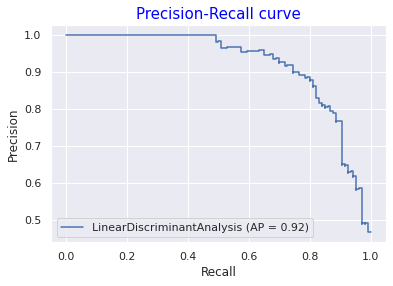

In [ ]:
# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis().fit(X_sig_train, y_train)
y_pred = lda.predict(X_sig_val)
acc_lda = lda.score(X_sig_val, y_val)
bacc_lda = balanced_accuracy_score(y_val, y_pred)
print("Accuracy and balance accuracy of lda classifier on validation set: %3.2f, %3.2f" % (acc_lda, bacc_lda))
print("Precision, recall, and F1-score of LDA classifier: %3.2f, %3.2f, %3.2f" %(precision_score(y_val, y_pred),recall_score(y_val, y_pred),f1_score(y_val, y_pred)))
disp = plot_precision_recall_curve(lda, X_sig_val, y_val)
plt.title('Precision-Recall curve', size=15, color='blue')
plt.show()

# 4. Prediction results


## 4.1. Test data preparation

### Feature extraction

In [ ]:
# (Testing) Trip Data 
path = r'/content/drive/MyDrive/Colab Notebooks/work_sample/work_sample_test_trips'
all_files = glob.glob(path + "/*.csv")

numTurns = []
numStops = []
for filename in all_files:
    data = pd.read_csv(filename, index_col=None, header=0)
    # remove invalid values
    data = data.dropna()
    
    x = data['time_seconds']
    y = data['heading_degrees']
    z = data['speed_meters_per_second']

    _turnMax, _turnMin = peakdetect(y, x, 3, 65)
    _stopMax, _stopMin = zeropeakdetect(z, x, 3, 10)
    numTurns.append(len(_turnMax) + len(_turnMin))
    numStops.append(len(_stopMin))

### Testing data

In [ ]:
# testing data
testdt = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/work_sample/model_data_test.csv', index_col=None, header=0)
testdt.info()

# selected features
sel_colnames = ['feature1', 'feature3', 'feature4', 'feature5', 'feature7', 'feature8', 'feature9', 'log_feature11', 'log_feature12', 'numTurns', 'numStops']
num_feature1 = testdt['feature1']*1
pro_testdt = pd.DataFrame(num_feature1)
pro_testdt.insert(1, 'feature3', testdt['feature3']*1)
pro_testdt.insert(2, 'feature4', testdt['feature4'])
pro_testdt.insert(3, 'feature5', testdt['feature5'])
pro_testdt.insert(4, 'feature7', testdt['feature7'])
pro_testdt.insert(5, 'feature8', testdt['feature8'])
pro_testdt.insert(6, 'feature9', testdt['feature9'])
log_feature11 = [math.log(testdt['feature11'][i]) for i in range(len(testdt['feature11']))]
log_feature12 = [math.log(testdt['feature12'][i]) for i in range(len(testdt['feature12']))]
pro_testdt.insert(7, 'log_feature11', log_feature11)
pro_testdt.insert(8, 'log_feature12', log_feature12)
pro_testdt.insert(9, 'numTurns', numTurns)
pro_testdt.insert(10, 'numStops', numStops)

# standardization
stand_testdt = pro_testdt.copy()
for id, col in enumerate(sel_colnames):
    if id>1:
      scale = StandardScaler().fit(pro_testdt[[col]])
      stand_testdt[col] = scale.transform(pro_testdt[[col]])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876 entries, 0 to 875
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   filename   876 non-null    object 
 1   feature1   876 non-null    bool   
 2   feature2   876 non-null    bool   
 3   feature3   876 non-null    bool   
 4   feature4   876 non-null    float64
 5   feature5   876 non-null    float64
 6   feature6   876 non-null    float64
 7   feature7   876 non-null    float64
 8   feature8   876 non-null    int64  
 9   feature9   876 non-null    int64  
 10  feature10  876 non-null    int64  
 11  feature11  876 non-null    float64
 12  feature12  876 non-null    float64
 13  feature13  876 non-null    float64
 14  feature14  876 non-null    float64
dtypes: bool(3), float64(8), int64(3), object(1)
memory usage: 84.8+ KB


## 4.2. Prediction

### Use all processed features

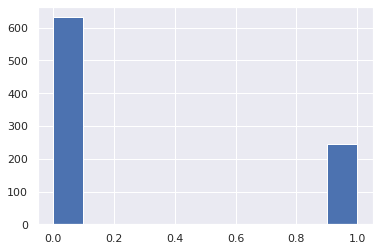

In [ ]:
# Linear Discriminant Analysis on the whole training data
lda = LinearDiscriminantAnalysis().fit(stand_features, pro_traindt['y'])
y_pred = lda.predict(stand_testdt)
plt.hist(y_pred)
plt.show()
res = pd.DataFrame({'file name': testdt['filename'], 'prediction': y_pred})
res.to_csv('PredictionResultAllFeatures.csv')

### Use only features that are statistically significant

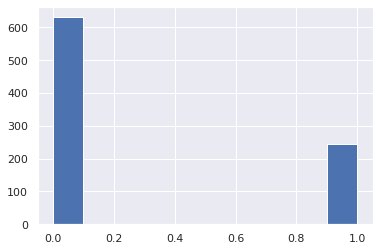

In [ ]:
sig_features = ['feature1', 'feature3', 'feature4', 'feature5', 'feature7', 'feature8', 'feature9']
# Linear Discriminant Analysis on the whole training data
lda = LinearDiscriminantAnalysis().fit(stand_features[sig_features], pro_traindt['y'])
y_pred = lda.predict(stand_testdt[sig_features])
plt.hist(y_pred)
plt.show()
res = pd.DataFrame({'file name': testdt['filename'], 'prediction': y_pred})
res.to_csv('PredictionResultSigFeatures.csv')

The prediction results of two cases are identical.